In [1]:
NUM_CLUSTERS = 5
BATCH_SIZE = 5
NUM_STEPS = 50

LON_ANI_CENTER = [-87.73, -87.60]
LAT_ANI_CENTER = [41.85, 42.00]

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib import animation
from matplotlib.patches import Ellipse
from IPython.display import HTML
plt.rcParams.update({'figure.max_open_warning': 0})

from scipy.stats import mode
import scipy.stats as sts

import numpy as np
import tensorflow as tf
from geopy.geocoders import Nominatim

import io
import base64
from dateutil import parser

In [29]:
data = pd.read_csv('/home/ann/python/citibike/citibike-tripdata.csv', sep=',')

columns = data.columns
types = list(data.dtypes)



tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object

In [21]:
data17.dtypes

tripduration               object
starttime                  object
stoptime                   object
start station id           object
start station name         object
start station latitude     object
start station longitude    object
end station id             object
end station name           object
end station latitude       object
end station longitude      object
bikeid                     object
usertype                   object
birth year                 object
gender                     object
dtype: object

In [57]:
data16 = pd.read_csv('/home/ann/python/citibike/JC-20161-citibike-tripdata.csv', sep = ',', names=columns)
data16.drop(data16.index[0], inplace=True)
data16 = data16.astype(dict(zip(columns, types)), errors='raise')

data17 = pd.read_csv('/home/ann/python/citibike/JC-201701-citibike-tripdata.csv', sep = ',', names=columns)
data17.drop(data17.index[0], inplace=True)
data17 = data17.astype(dict(zip(columns, types)), errors='raise')

data18 = pd.read_csv('/home/ann/python/citibike/JC-201801-citibike-tripdata.csv', sep = ',', names=columns)
data18.drop(data18.index[0], inplace=True)
data18 = data18.astype(dict(zip(columns, types)), errors='raise')

dataset= pd.concat([ data,  data16, data17, data18])
print(data.shape[0]+ data16.shape[0]+ data17.shape[0]+ data18.shape[0])
dataset.shape
# dataset.dtypes


56664


(56664, 15)

In [58]:
# соединим точки посаки и высадки (latitude - широта, longitude - долгота)
latitude = list(dataset['start station latitude'])+list(dataset['end station latitude'])
print('max latitude', str(max(latitude)))
print('min latitude', str(min(latitude)))

longitude = list(dataset['start station longitude'])+list(dataset['end station longitude'])
print('max longitude', str(max(longitude)))
print('min longitude', str(min(longitude)))


loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude


max latitude 40.8013434
min latitude 40.69263996618329
max longitude -73.97114574390001
min longitude -74.0969366


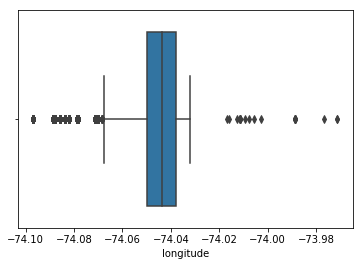

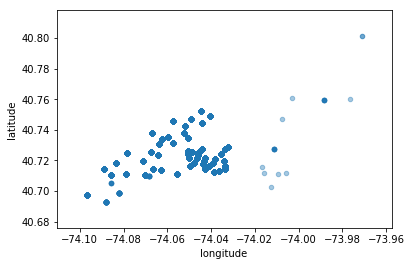

In [108]:
# plt.boxplot(loc_df.longitude)
sns.boxplot(loc_df.longitude)
loc_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.show()

<Figure size 720x720 with 0 Axes>

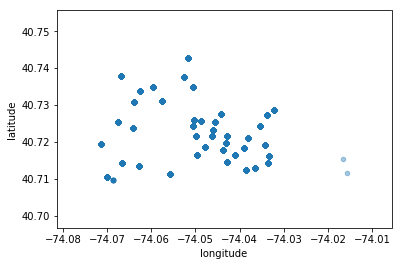

In [96]:
z = np.abs(sts.zscore(loc_df))
threshold = 3
loc_df_o = loc_df[(z < 3).all(axis=1)]
loc_df_o.shape
# sns.boxplot(loc_df_o.latitude)
# plt.boxplot(loc_df.longitude)
plt.figure(figsize = (10,10))
loc_df_o.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.show()

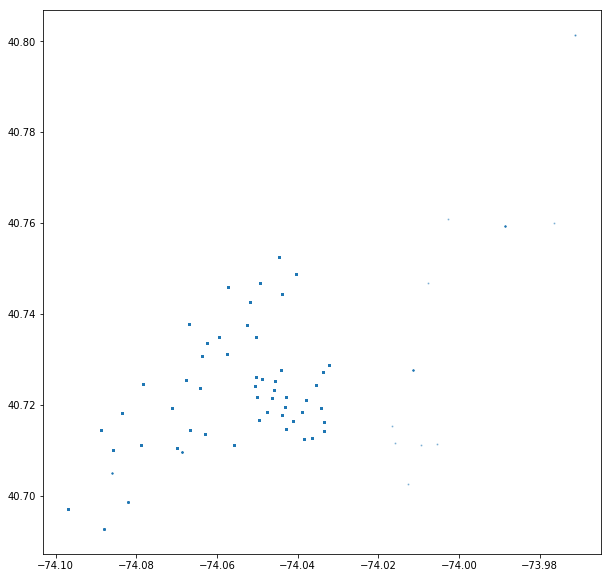

In [88]:
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 2)
plt.show()

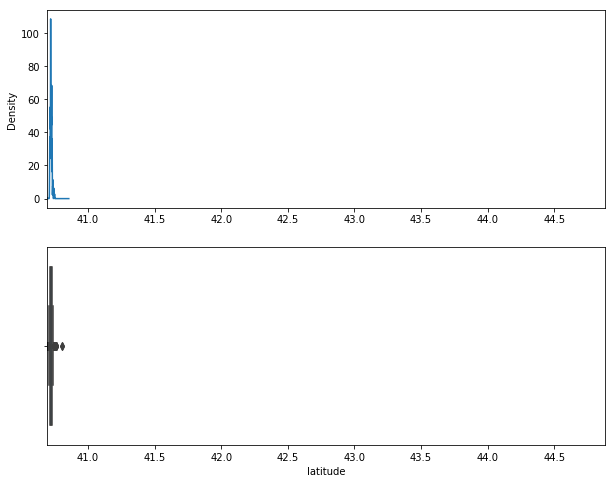

In [65]:
data16 = pd.read_csv('/home/ann/python/citibike/JC-20161-citibike-tripdata.csv', sep = ',', names=columns)
data16.drop(index =  0)
data17 = pd.read_csv('/home/ann/python/citibike/JC-201701-citibike-tripdata.csv', sep = ',', names=columns)
data17.drop(index =  0)
data18 = pd.read_csv('/home/ann/python/citibike/JC-201801-citibike-tripdata.csv', sep = ',', names=columns)
data18.drop(index =  0)
dataset= pd.concat([ data, data16, data17, data18])
print(data.shape[0]+ data16.shape[0]+ data17.shape[0]+ data18.shape[0])

np.std(loc_df.longitude)

56667


0.01064184927698084

/home/ann/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ann/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


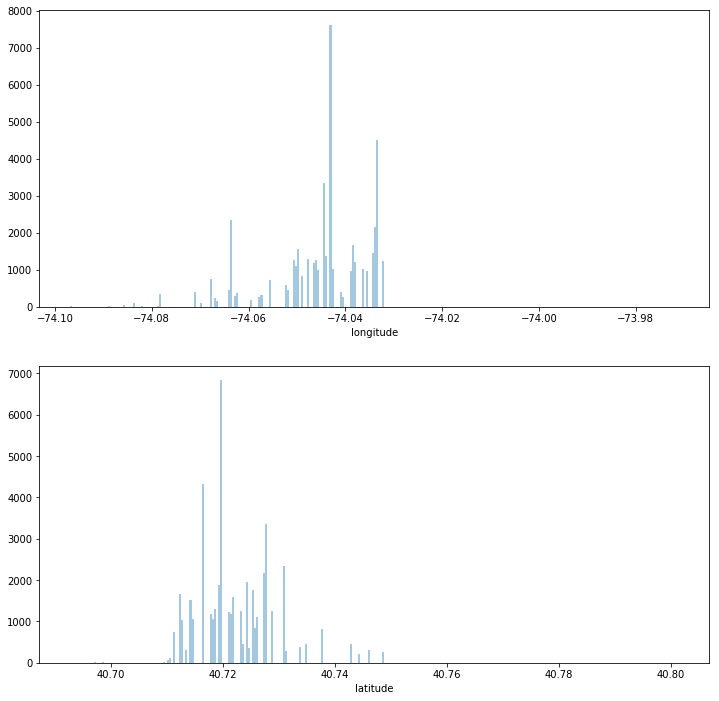

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (12, 12))
sns.distplot(loc_df['longitude'], bins=300, kde=False, ax=ax1)
sns.distplot(loc_df['latitude'], bins=300, kde=False, ax=ax2)

plt.show();

In [7]:
print('The most frequent values : \n', loc_df.mode())
LON_CONST, LAT_CONST = loc_df.mode().iloc[0].round(4)

data_array =[[(lon-LON_CONST), (lat-LAT_CONST)] for lon, lat in zip(longitude, latitude)]
data_array = np.array(data_array)

The most frequent values : 
    longitude   latitude
0 -74.043117  40.719586


In [9]:
def clustering_KMeans(num_clasters = 5, flag_print = True):
    X = tf.placeholder(tf.float32, shape = [None, 2])
    
    kmeans = tf.contrib.factorization.KMeans (
        inputs = X, 
        num_clasters = num_clasters,
        initial_clusters="kmeans_plus_plus",
        mini_batch_steps_per_iteration =BATCH_SIZE, 
        random_seed=29,
        use_mini_batch=True)
    
    (all_scores,cluster_idx, scores,cluster_centers_initialized,\
     cluster_centers_var,init_op,train_op) = kmeans.training_graph()
    
    distance = tf.reduce_mean(scores)
    cluster_idx = cluster_idx[0]
    
    inglobvar = tf.global_variables_initializer()
    session = tf.Session()
    session.run(inglobvar)
    sess.run(init_op, feed_dict={X: data})

    for i in range(1, NUM_STEPS+1):
        _, d, idx, cl_c = sess.run([train_op, 
                                    avg_distance,
                                    cluster_idx,
                                    cluster_centers_var],
                                    feed_dict={X: data}
                            )
        
        if (i%10==0)&(flag_print):
            print('Step %i, Average Distance %.8f'%(i, d))
    sess.close()
    return d,idx,cl_c
    

In [48]:
df = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv', sep=',')

In [64]:
print(np.std(df.latitude),
np.std(df.longitude))


2.13590065379748 2.003483187746969


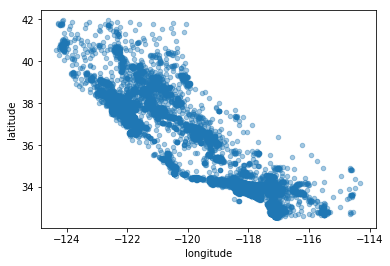

In [63]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.show()

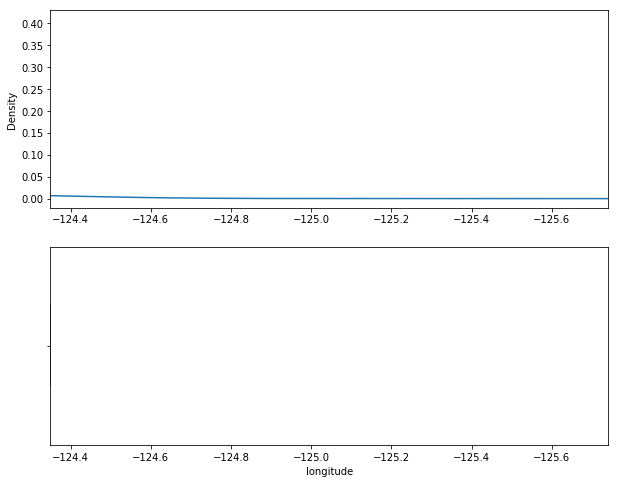

In [71]:

i = 'longitude'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i])